In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import logging
import matplotlib.pyplot as plt




## Set up Logging

In [2]:
# Set up the basic configuration for logging
logging.basicConfig(
    level=logging.INFO,  # Set the threshold for the logger to the INFO level
    format='%(asctime)s - %(levelname)s - %(message)s'  # Define the format of the log messages
)
logger = logging.getLogger(__name__)  # Create a logger object with the name of the current module

### Load your data

In [3]:
logger.info("Loading train_data...")
train_data = pd.read_csv('C:\\Users\\King Betse\\Downloads\\rossmann-store-sales\\train.csv')
logger.info("Loaded train_data successfully.")
        
logger.info("Loading test_data...")
test_data = pd.read_csv('C:\\Users\\King Betse\\Downloads\\rossmann-store-sales\\test.csv')
logger.info("Loaded test_data successfully.")
        
logger.info("Loading sample_submission...")
sample_submission = pd.read_csv('C:\\Users\\King Betse\\Downloads\\rossmann-store-sales\\sample_submission.csv')
logger.info("Loaded sample_submission successfully.")
        
logger.info("Loading store...")
store = pd.read_csv('C:\\Users\\King Betse\\Downloads\\rossmann-store-sales\\store.csv')
logger.info("Loaded store successfully.")


2024-09-23 22:58:45,519 - INFO - Loading train_data...
C:\Users\King Betse\AppData\Local\Temp\ipykernel_7056\1374655973.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('C:\\Users\\King Betse\\Downloads\\rossmann-store-sales\\train.csv')
2024-09-23 22:58:46,131 - INFO - Loaded train_data successfully.
2024-09-23 22:58:46,131 - INFO - Loading test_data...
2024-09-23 22:58:46,182 - INFO - Loaded test_data successfully.
2024-09-23 22:58:46,183 - INFO - Loading sample_submission...
2024-09-23 22:58:46,214 - INFO - Loaded sample_submission successfully.
2024-09-23 22:58:46,214 - INFO - Loading store...
2024-09-23 22:58:46,221 - INFO - Loaded store successfully.


## Preprocessing

### Handle Missing Values

In [4]:
train_data.fillna(method='ffill', inplace=True)  # Forward fill as an example

C:\Users\King Betse\AppData\Local\Temp\ipykernel_7056\3349743448.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data.fillna(method='ffill', inplace=True)  # Forward fill as an example


### Convert Date Column

In [5]:
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


###  Feature Extraction

In [6]:
train_data['Weekday'] = train_data['Date'].dt.weekday  # 0-6 (Monday-Sunday)
train_data['Weekend'] = (train_data['Weekday'] >= 5).astype(int)  # 1 if Weekend, else 0

# Define known holidays 
holiday_dates = pd.to_datetime(['2013-01-01', '2014-01-01', '2015-01-01',
                                 '2013-12-25', '2014-12-25', '2015-12-25'])

# Function to calculate days to next holiday
def days_to_next_holiday(date):
    next_holiday = holiday_dates[holiday_dates > date]
    return (next_holiday.min() - date).days if not next_holiday.empty else float('inf')

# Function to calculate days since last holiday
def days_since_last_holiday(date):
    last_holiday = holiday_dates[holiday_dates < date]
    return (date - last_holiday.max()).days if not last_holiday.empty else float('inf')

# Calculate Days To Holiday and Days After Holiday
train_data['DaysToHoliday'] = train_data['Date'].apply(days_to_next_holiday)
train_data['DaysAfterHoliday'] = train_data['Date'].apply(days_since_last_holiday)
train_data['BeginningOfMonth'] = (train_data['Date'].dt.day == 1).astype(int)
train_data['MidMonth'] = ((train_data['Date'].dt.day > 10) & (train_data['Date'].dt.day <= 20)).astype(int)
train_data['EndOfMonth'] = (train_data['Date'].dt.day == train_data['Date'].dt.days_in_month).astype(int)

# Additional Feature Extraction
train_data['Month'] = train_data['Date'].dt.month  # Month as a number (1-12)

# Define seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

train_data['Season'] = train_data['Month'].apply(get_season)  # Season as a categorical variable

train_data['IsHoliday'] = train_data['Date'].isin(holiday_dates).astype(int)  # Binary indicator for holidays






### Encode Categorical Data

In [7]:
train_data['Promo'] = train_data['Promo'].astype(int)  # Ensure Promo is numeric
train_data['StateHoliday'] = train_data['StateHoliday'].map({'a': 1, 'b': 1, 'c': 1, '0': 0})  # Map holidays to binary
train_data['SchoolHoliday'] = train_data['SchoolHoliday'].astype(int)  # Ensure SchoolHoliday is numeric

### Scale the Features

In [8]:
from sklearn.preprocessing import StandardScaler

# Scale the Features
scaler = StandardScaler()
features_to_scale = ['Sales', 'Customers', 'Open', 'Weekday', 'Weekend', 
                     'DaysToHoliday', 'DaysAfterHoliday', 
                     'BeginningOfMonth', 'MidMonth', 'EndOfMonth', 
                     'Promo', 'StateHoliday', 'SchoolHoliday', 
                     'Month']  # Include Month in scaling if needed
# Check for infinite values
if np.isinf(train_data[features_to_scale]).any().any():
    print("Infinite values found. Replacing with NaN.")
    train_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check for NaN values
if train_data[features_to_scale].isnull().any().any():
    print("NaN values found. Filling NaN values with the mean.")
    train_data.fillna(train_data[features_to_scale].mean(), inplace=True)

# Now proceed to scale the features
scaler = StandardScaler()
train_data[features_to_scale] = scaler.fit_transform(train_data[features_to_scale])

# Preview the scaled data
print(train_data[features_to_scale].head())
# Preview the processed training data
print(train_data.head())

Infinite values found. Replacing with NaN.
NaN values found. Filling NaN values with the mean.
      Sales  Customers      Open   Weekday   Weekend  DaysToHoliday  \
0 -0.132683  -0.168269  0.452399  0.501484 -0.630672      -0.491223   
1  0.075373  -0.017540  0.452399  0.501484 -0.630672      -0.491223   
2  0.659800   0.404499  0.452399  0.501484 -0.630672      -0.491223   
3  2.135414   1.862258  0.452399  0.501484 -0.630672      -0.491223   
4 -0.247231  -0.159656  0.452399  0.501484 -0.630672      -0.491223   

   DaysAfterHoliday  BeginningOfMonth  MidMonth  EndOfMonth     Promo  \
0            0.5362         -0.184494 -0.700517    5.420152  1.273237   
1            0.5362         -0.184494 -0.700517    5.420152  1.273237   
2            0.5362         -0.184494 -0.700517    5.420152  1.273237   
3            0.5362         -0.184494 -0.700517    5.420152  1.273237   
4            0.5362         -0.184494 -0.700517    5.420152  1.273237   

   StateHoliday  SchoolHoliday     Mont

## Building Models with sklearn Pipelines

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Define features and target variable
X = train_data.drop(columns=['Sales'])  # Features
y = train_data['Sales']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Create a preprocessing pipeline


In [10]:
# specific transformers for different feature types if needed
numeric_features = X_train.select_dtypes(include=['float64', 'int']).columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Complete column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

# final pipeline with preprocessing and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Store', 'DayOfWeek',
                                                   'Customers', 'Open', 'Promo',
                                                   'StateHoliday',
                                                   'SchoolHoliday', 'Weekday',
                                                   'Weekend', 'DaysToHoliday',
                                                   'DaysAfterHoliday',
                                                   'BeginningOfMonth',
                                                   'MidMonth', 'EndOfMonth',
                                                   'Month', 'IsHoliday'])])),
                ('model', RandomForestRegressor(random_state=42))])

### Evaluate the model

In [11]:
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"Training R^2 Score: {train_score:.4f}")
print(f"Testing R^2 Score: {test_score:.4f}")

Training R^2 Score: 0.9952
Testing R^2 Score: 0.9654


### Loss function

In [12]:
from sklearn.metrics import mean_absolute_error

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Absolute Error (MAE): 0.11


## Post Prediction Analysis


In [13]:
# Fit the model again to access feature importances
pipeline.fit(X_train, y_train)

# Get the Random Forest model from the pipeline
model = pipeline.named_steps['model']

# Get feature importances
importances = model.feature_importances_

# Ensure you get the correct feature names from the preprocessor
feature_names = pipeline.named_steps['preprocessor'].transformers_[0][2]

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

###  Visulisation feature importances

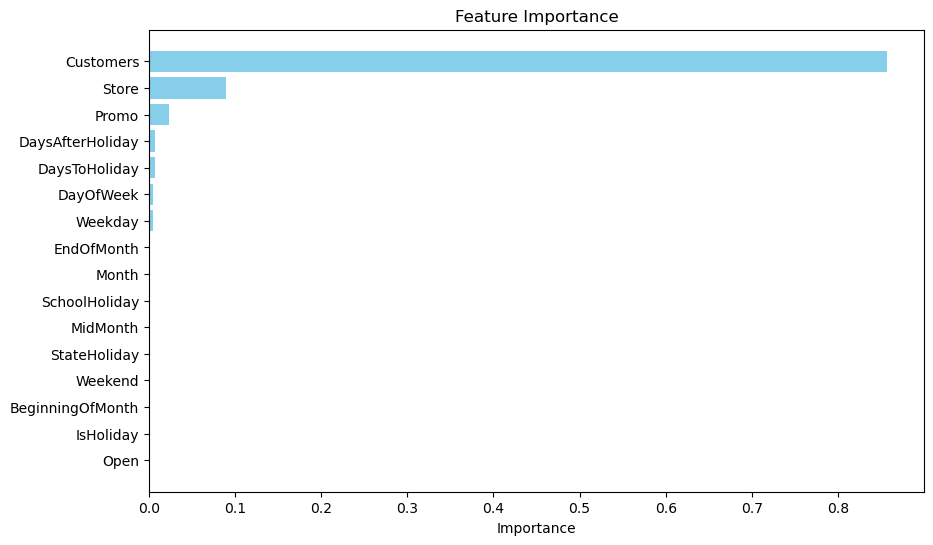

In [14]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

## Serialize models

In [15]:
import joblib
from datetime import datetime

# Generate a timestamp
timestamp = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")

# Define the filename with the timestamp
filename = f"model_{timestamp}.pkl"

# Serialize the model
joblib.dump(pipeline, filename)

print(f"Model saved as: {filename}")

Model saved as: model_23-09-2024-23-23-18.pkl


In [16]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Prepare the Dataset

In [17]:
# Convert 'Date' to datetime format
train_data['Date'] = pd.to_datetime(train_data['Date'])

# Group by date and sum sales
sales_data = train_data.groupby('Date')['Sales'].sum().reset_index()

sales_data

,Date,Sales
0,2013-01-01,-1645.434785
1,2013-01-02,132.995043
2,2013-01-03,-23.374006
3,2013-01-04,52.246702
4,2013-01-05,-126.292134
...,...,...
937,2015-07-27,1108.978653
938,2015-07-28,695.407143
939,2015-07-29,535.634910
940,2015-07-30,613.270722


### Check for Stationarity

In [18]:
def test_stationarity(timeseries):
    result = adfuller(timeseries['Sales'])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    
test_stationarity(sales_data)

ADF Statistic: -5.732750711060446
p-value: 6.542733316184592e-07


### Check Autocorrelation and Partial Autocorrelation

<Figure size 1200x600 with 0 Axes>

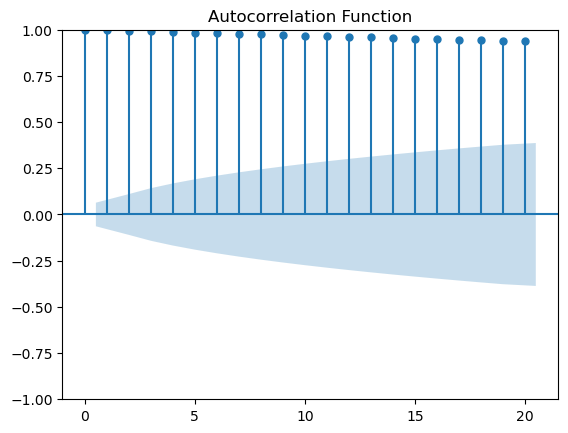

<Figure size 1200x600 with 0 Axes>

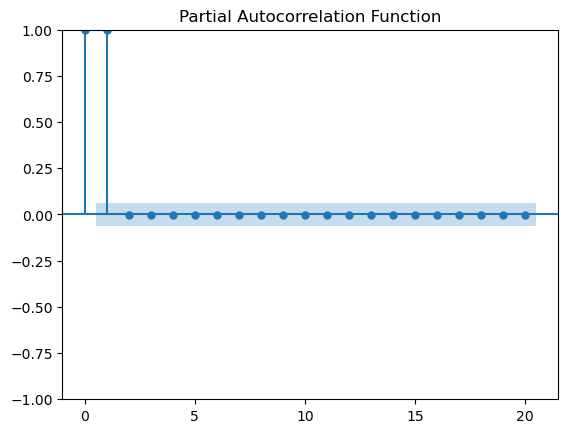

In [23]:
plt.figure(figsize=(12, 6))
plot_acf(sales_data['Date'], lags=20)
plt.title('Autocorrelation Function')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(sales_data['Date'], lags=20)
plt.title('Partial Autocorrelation Function')
plt.show()

### Transform Data into Supervised Learning Format

In [27]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Scale the data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(sales_data[['Sales']])

# Create the dataset
time_step = 10  # Number of previous observations to consider
X, y = create_dataset(scaled_data, time_step)

# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

### Build the LSTM Model

In [28]:
# Define the LSTM model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(tf.keras.layers.LSTM(50))
model.add(tf.keras.layers.Dense(1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=50, batch_size=32)

Epoch 1/50


C:\Users\King Betse\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1967
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1723
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1545
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1420
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1512
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1590
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1536
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1602
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1675
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1512
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1494
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1592
Epoch 13/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1428
Epoch 14/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1533
Epoch 15/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1446
Epoch 16/50
30/30 ━━━━━━━━━━━━

### Making Predictions

In [29]:
# Making predictionss
last_data = scaled_data[-time_step:]
last_data = last_data.reshape(1, time_step, 1)

predicted_diff = model.predict(last_data)
predicted_sales = scaler.inverse_transform(predicted_diff)  # Transform back to original scalee

print(f'Predicted Sales: {predicted_sales[0][0]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
Predicted Sales: 175.485107421875
